In [1]:
import scanpy as sc
import gseapy as gp
import matplotlib.pyplot as plt
import gseapy as gp
import anndata as ad
import decoupler
from pathlib import Path

/home/icb/dominik.klein/mambaforge/envs/cfp/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
split = 2

In [3]:
adata_pred_ood = sc.read(f"/lustre/groups/ml01/workspace/ot_perturbation/models/otfm/combosciplex/adata_ood_with_predictions_{split}.h5ad")
#adata_pred_test = sc.read(f"/lustre/groups/ml01/workspace/ot_perturbation/models/otfm/combosciplex/adata_test_with_predictions_{split}.h5ad")

In [4]:
adata_pred_ood.X = adata_pred_ood.layers["X_recon_pred"]
#adata_pred_test.X = adata_pred_test.layers["X_recon_pred"]

In [5]:
adata_train_path = f"/lustre/groups/ml01/workspace/ot_perturbation/data/combosciplex/adata_train_{split}.h5ad"
adata_test_path = f"/lustre/groups/ml01/workspace/ot_perturbation/data/combosciplex/adata_test_{split}.h5ad"
adata_ood_path = f"/lustre/groups/ml01/workspace/ot_perturbation/data/combosciplex/adata_ood_{split}.h5ad"

In [6]:
adata_train = sc.read(adata_train_path)
adata_test = sc.read(adata_test_path)
adata_ood = sc.read(adata_ood_path)

In [7]:
adata_pred_ood = adata_pred_ood[adata_pred_ood.obs["condition"]!="control"]

In [8]:
adata_pred_ood.var_names = adata_ood.var_names
#adata_pred_test.var_names = adata_test.var_names

In [9]:
adata_pred_ood.obs["condition"] = adata_pred_ood.obs.apply(lambda x: x["condition"] + "_pred", axis=1)

In [10]:
adata_full = ad.concat((adata_train, adata_ood, adata_pred_ood))

In [11]:
sc.pp.normalize_total(adata_full)

In [12]:
if not Path("c2.cp.reactome.v7.5.1.symbols.gmt").is_file():
    !wget -O 'c2.cp.reactome.v7.5.1.symbols.gmt' https://figshare.com/ndownloader/files/35233771

In [13]:
import pandas as pd
def gmt_to_decoupler(pth: Path) -> pd.DataFrame:
    """
    Parse a gmt file to a decoupler pathway dataframe.
    """
    from itertools import chain, repeat

    pathways = {}

    with Path(pth).open("r") as f:
        for line in f:
            name, _, *genes = line.strip().split("\t")
            pathways[name] = genes

    return pd.DataFrame.from_records(
        chain.from_iterable(zip(repeat(k), v) for k, v in pathways.items()),
        columns=["geneset", "genesymbol"],
    )



In [14]:
reactome = gmt_to_decoupler("c2.cp.reactome.v7.5.1.symbols.gmt")

In [15]:
# Retrieving via python
msigdb = decoupler.get_resource("MSigDB")

# Get reactome pathways
reactome = msigdb.query("collection == 'reactome_pathways'")
# Filter duplicates
reactome = reactome[~reactome.duplicated(("geneset", "genesymbol"))]


  File "/home/icb/dominik.klein/mambaforge/envs/cfp/lib/python3.11/site-packages/urllib3/connectionpool.py", line 466, in _make_request
    self._validate_conn(conn)
  File "/home/icb/dominik.klein/mambaforge/envs/cfp/lib/python3.11/site-packages/urllib3/connectionpool.py", line 1095, in _validate_conn
    conn.connect()
  File "/home/icb/dominik.klein/mambaforge/envs/cfp/lib/python3.11/site-packages/urllib3/connection.py", line 652, in connect
    sock_and_verified = _ssl_wrap_socket_and_match_hostname(
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/icb/dominik.klein/mambaforge/envs/cfp/lib/python3.11/site-packages/urllib3/connection.py", line 805, in _ssl_wrap_socket_and_match_hostname
    ssl_sock = ssl_wrap_socket(
               ^^^^^^^^^^^^^^^^
  File "/home/icb/dominik.klein/mambaforge/envs/cfp/lib/python3.11/site-packages/urllib3/util/ssl_.py", line 465, in ssl_wrap_socket
    ssl_sock = _ssl_wrap_socket_impl(sock, context, tls_in_tls, server_hostnam

In [16]:
sc.tl.rank_genes_groups(adata_full, "condition", method="t-test", key_added="t-test", reference="control")

/home/icb/dominik.klein/mambaforge/envs/cfp/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/home/icb/dominik.klein/mambaforge/envs/cfp/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/home/icb/dominik.klein/mambaforge/envs/cfp/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/home/icb/dominik.klein/mambaforge/envs/cfp/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/home/icb/dominik.klein/mambaforge/envs/cfp/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: inv

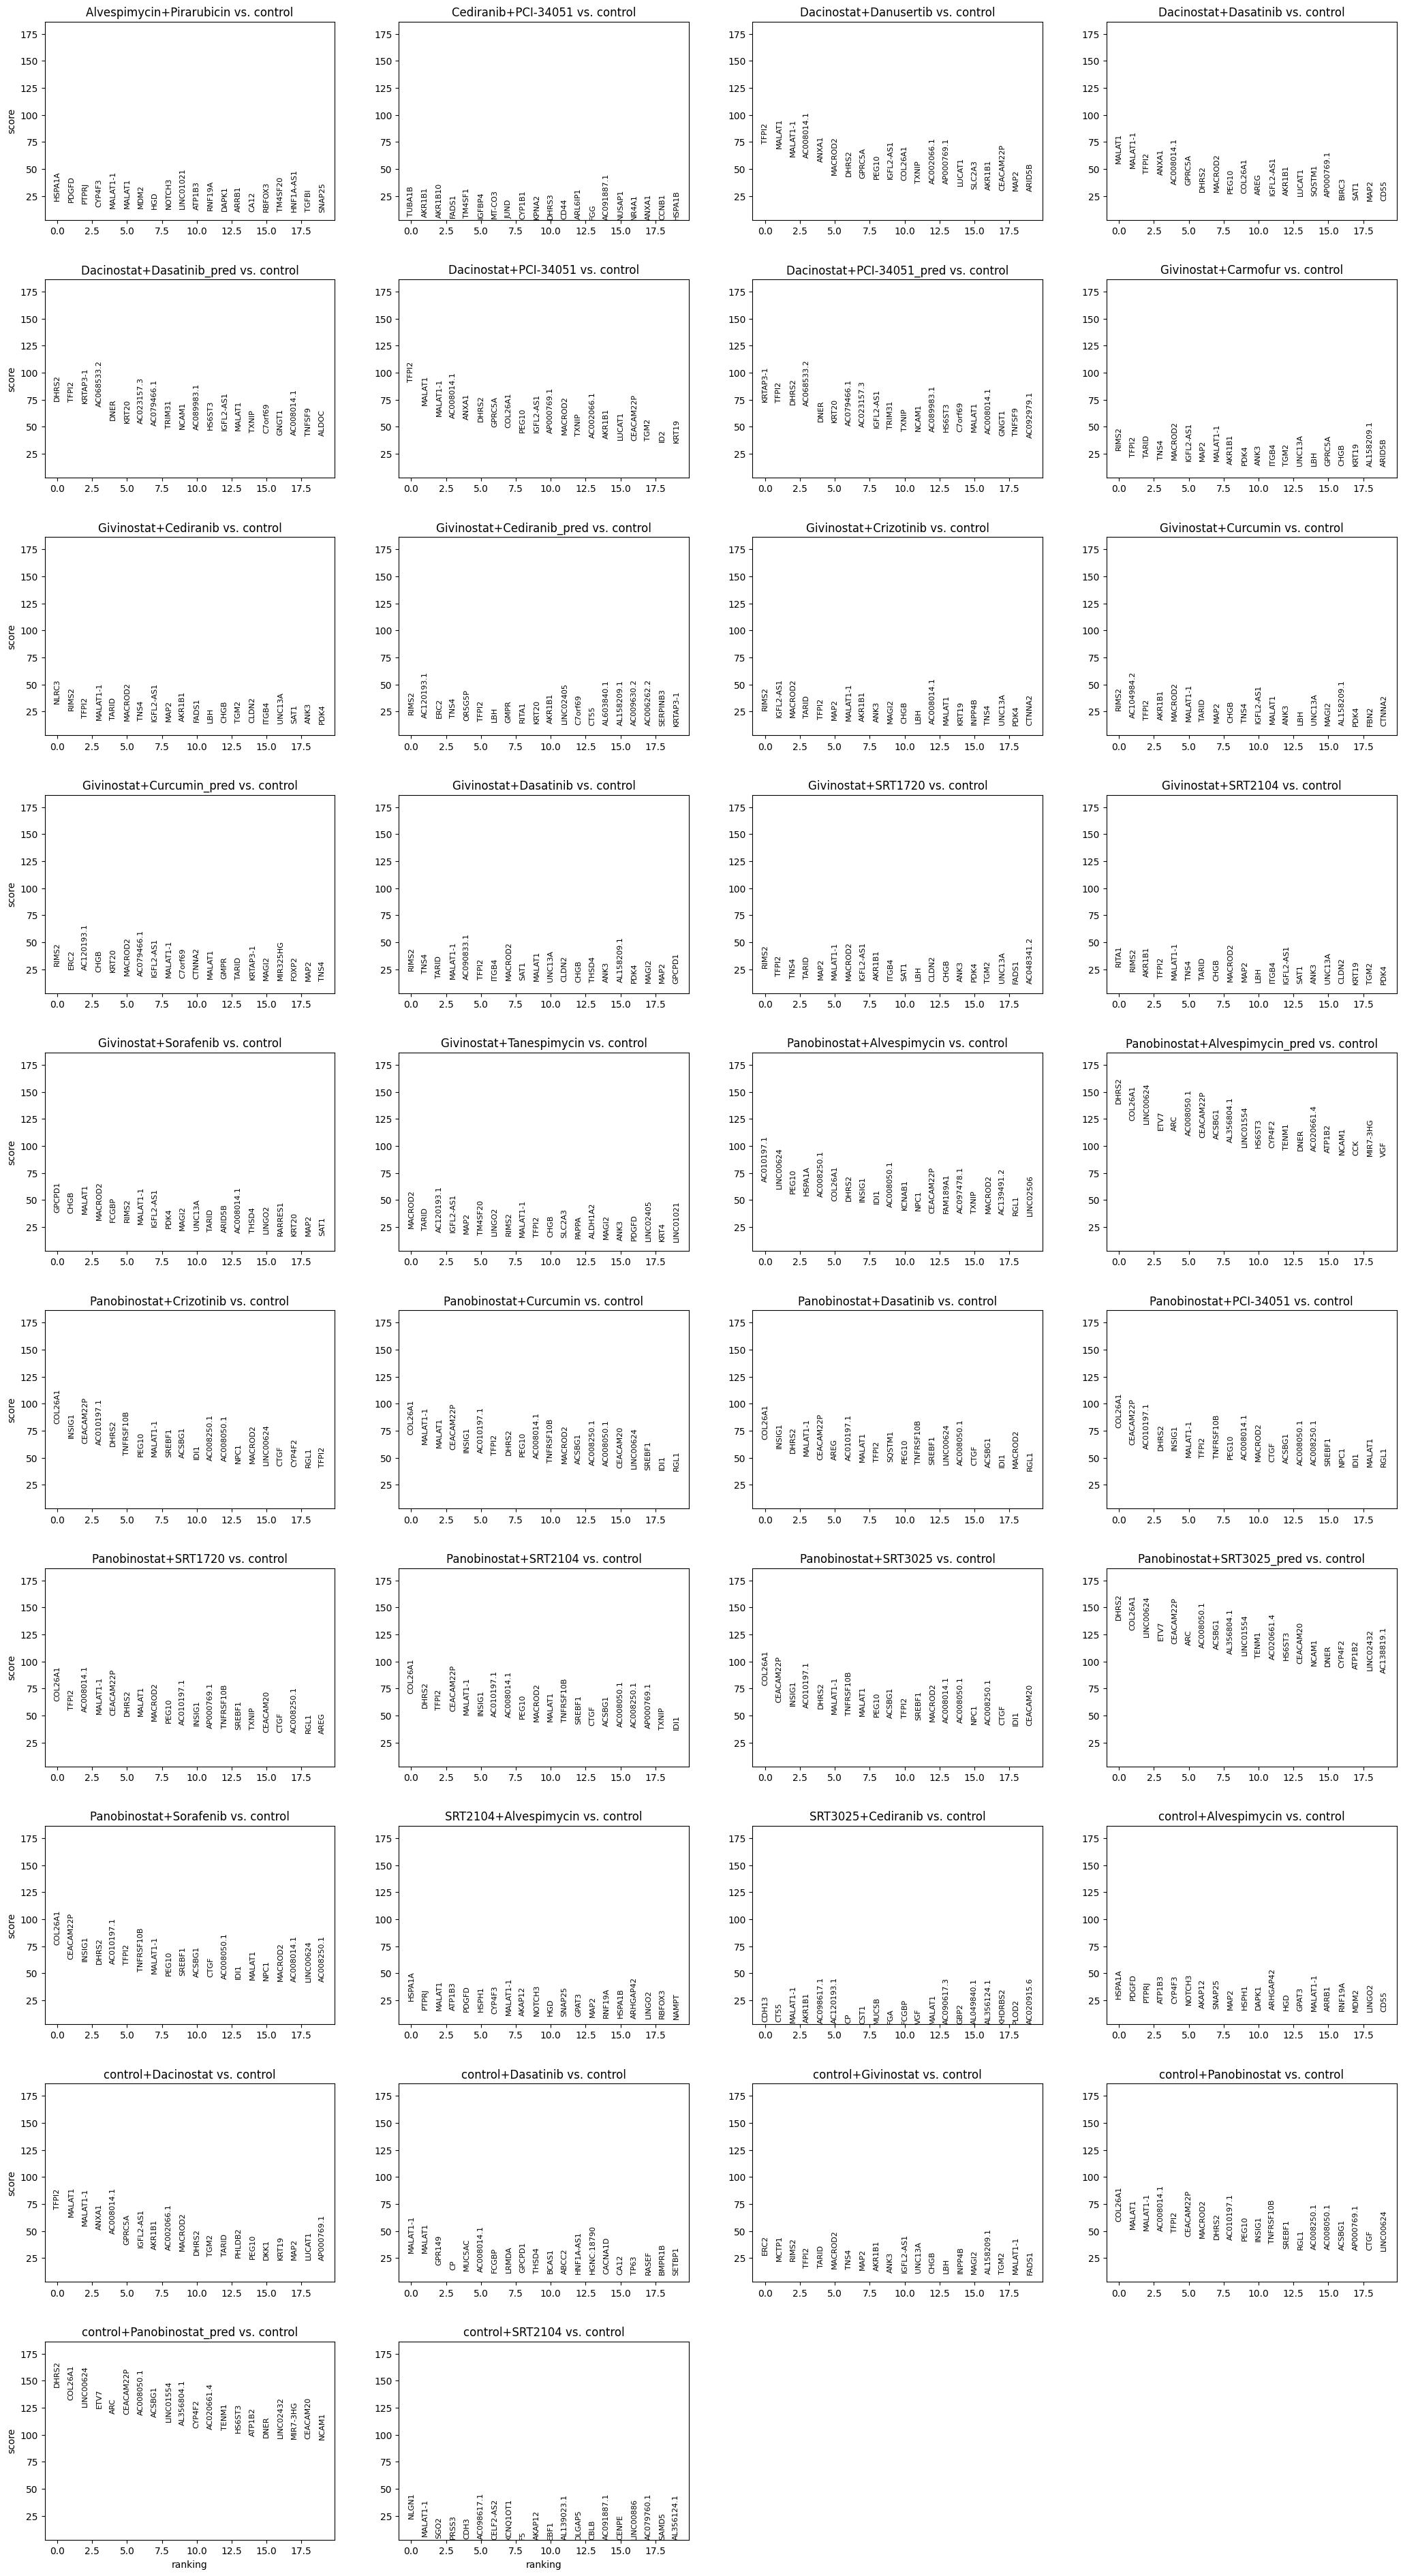

In [17]:
sc.pl.rank_genes_groups(adata_full, key="t-test")

In [18]:
import numpy as np
dict_t_stats = {}

for condition in adata_full.obs["condition"].cat.categories:
    if condition=="control":
        continue
    t_stats = (
        # Get dataframe of DE results for condition vs. rest
        sc.get.rank_genes_groups_df(adata_full, group=condition,  key="t-test")
        .set_index("names")
        # Sort by absolute score
        .sort_values("scores", key=np.abs, ascending=False)
        # Format for decoupler
        [["scores"]]
    )
    dict_t_stats[condition] = t_stats

In [19]:
# Filtering genesets to match behaviour of fgsea
geneset_size = reactome.groupby("geneset").size()
gsea_genesets = geneset_size.index[(geneset_size > 15) & (geneset_size < 500)]

/tmp/ipykernel_4024349/1613302725.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  geneset_size = reactome.groupby("geneset").size()


In [20]:
dict_gsea_results = {}

for condition, t_stats in dict_t_stats.items():
    scores, norm, pvals = decoupler.run_gsea(
        t_stats.T,
        reactome[reactome["geneset"].isin(gsea_genesets)],
        source="geneset",
        target="genesymbol",
    )
    gsea_results = (
        pd.concat({"score": scores.T, "norm": norm.T, "pval": pvals.T}, axis=1)
        .droplevel(level=1, axis=1)
        .sort_values("pval")
    )
    dict_gsea_results[condition] = gsea_results



In [21]:
dict_gsea_results.keys()

dict_keys(['Alvespimycin+Pirarubicin', 'Cediranib+PCI-34051', 'Dacinostat+Danusertib', 'Dacinostat+Dasatinib', 'Dacinostat+Dasatinib_pred', 'Dacinostat+PCI-34051', 'Dacinostat+PCI-34051_pred', 'Givinostat+Carmofur', 'Givinostat+Cediranib', 'Givinostat+Cediranib_pred', 'Givinostat+Crizotinib', 'Givinostat+Curcumin', 'Givinostat+Curcumin_pred', 'Givinostat+Dasatinib', 'Givinostat+SRT1720', 'Givinostat+SRT2104', 'Givinostat+Sorafenib', 'Givinostat+Tanespimycin', 'Panobinostat+Alvespimycin', 'Panobinostat+Alvespimycin_pred', 'Panobinostat+Crizotinib', 'Panobinostat+Curcumin', 'Panobinostat+Dasatinib', 'Panobinostat+PCI-34051', 'Panobinostat+SRT1720', 'Panobinostat+SRT2104', 'Panobinostat+SRT3025', 'Panobinostat+SRT3025_pred', 'Panobinostat+Sorafenib', 'SRT2104+Alvespimycin', 'SRT3025+Cediranib', 'control+Alvespimycin', 'control+Dacinostat', 'control+Dasatinib', 'control+Givinostat', 'control+Panobinostat', 'control+Panobinostat_pred', 'control+SRT2104'])

In [22]:
dict_gsea_results['Alvespimycin+Pirarubicin']

,score,norm,pval
source,,,
REACTOME_GOLGI_TO_ER_RETROGRADE_TRANSPORT,-0.915082,-1.823558,0.000000
REACTOME_DNA_REPAIR,-0.936920,-2.106235,0.000000
REACTOME_DNA_REPLICATION,-0.949367,-1.804436,0.000000
REACTOME_DNA_REPLICATION_PRE_INITIATION,-0.948767,-1.725367,0.000000
REACTOME_DNA_STRAND_ELONGATION,-0.948767,-1.731261,0.000000
...,...,...,...
REACTOME_AMINE_LIGAND_BINDING_RECEPTORS,-0.293485,-0.536247,0.938628
REACTOME_CHEMOKINE_RECEPTORS_BIND_CHEMOKINES,-0.276233,-0.479457,0.972325
REACTOME_TRANSCRIPTIONAL_REGULATION_OF_WHITE_ADIPOCYTE_DIFFERENTIATION,0.246314,0.466471,0.972973


In [23]:
[el for el in dict_gsea_results['Alvespimycin+Pirarubicin'].index if "TP53" in el]

['REACTOME_TRANSCRIPTIONAL_REGULATION_BY_TP53',
 'REACTOME_REGULATION_OF_TP53_ACTIVITY_THROUGH_PHOSPHORYLATION',
 'REACTOME_REGULATION_OF_TP53_ACTIVITY']

In [24]:
'REACTOME_REGULATION_OF_TP53_ACTIVITY' # 'Alvespimycin+Pirarubicin'
'REACTOME_REGULATION_OF_TP53_ACTIVITY' # maybe even more interesting, as it's for 'Givinostat+Tanespimycin' and 'Alvespimycin+Pirarubicin'
'REACTOME_TRANSCRIPTIONAL_REGULATION_BY_TP53' # affects many conditions, a bit random

'REACTOME_TRANSCRIPTIONAL_REGULATION_BY_TP53'

In [25]:
dict_gsea_results['Alvespimycin+Pirarubicin']

,score,norm,pval
source,,,
REACTOME_GOLGI_TO_ER_RETROGRADE_TRANSPORT,-0.915082,-1.823558,0.000000
REACTOME_DNA_REPAIR,-0.936920,-2.106235,0.000000
REACTOME_DNA_REPLICATION,-0.949367,-1.804436,0.000000
REACTOME_DNA_REPLICATION_PRE_INITIATION,-0.948767,-1.725367,0.000000
REACTOME_DNA_STRAND_ELONGATION,-0.948767,-1.731261,0.000000
...,...,...,...
REACTOME_AMINE_LIGAND_BINDING_RECEPTORS,-0.293485,-0.536247,0.938628
REACTOME_CHEMOKINE_RECEPTORS_BIND_CHEMOKINES,-0.276233,-0.479457,0.972325
REACTOME_TRANSCRIPTIONAL_REGULATION_OF_WHITE_ADIPOCYTE_DIFFERENTIATION,0.246314,0.466471,0.972973


In [26]:
res = {}
res_score = {}
res_norm = {}
for cond, df in dict_gsea_results.items():
    res[cond] = df.loc['REACTOME_REGULATION_OF_TP53_ACTIVITY_THROUGH_PHOSPHORYLATION']["pval"]
    res_score[cond] = df.loc['REACTOME_REGULATION_OF_TP53_ACTIVITY_THROUGH_PHOSPHORYLATION']["score"]
    res_norm[cond] = df.loc['REACTOME_REGULATION_OF_TP53_ACTIVITY_THROUGH_PHOSPHORYLATION']["norm"]

In [27]:
res

{'Alvespimycin+Pirarubicin': 0.04107425,
 'Cediranib+PCI-34051': 0.73747015,
 'Dacinostat+Danusertib': 0.0,
 'Dacinostat+Dasatinib': 0.0,
 'Dacinostat+Dasatinib_pred': 0.0,
 'Dacinostat+PCI-34051': 0.0,
 'Dacinostat+PCI-34051_pred': 0.0,
 'Givinostat+Carmofur': 0.0,
 'Givinostat+Cediranib': 0.0,
 'Givinostat+Cediranib_pred': 0.0,
 'Givinostat+Crizotinib': 0.0,
 'Givinostat+Curcumin': 0.0,
 'Givinostat+Curcumin_pred': 0.0,
 'Givinostat+Dasatinib': 0.0,
 'Givinostat+SRT1720': 0.0,
 'Givinostat+SRT2104': 0.0,
 'Givinostat+Sorafenib': 0.0,
 'Givinostat+Tanespimycin': 0.0,
 'Panobinostat+Alvespimycin': 0.006048387,
 'Panobinostat+Alvespimycin_pred': 0.0,
 'Panobinostat+Crizotinib': 0.008528785,
 'Panobinostat+Curcumin': 0.0043763677,
 'Panobinostat+Dasatinib': 0.008810572,
 'Panobinostat+PCI-34051': 0.00921659,
 'Panobinostat+SRT1720': 0.0024390244,
 'Panobinostat+SRT2104': 0.0022675737,
 'Panobinostat+SRT3025': 0.0,
 'Panobinostat+SRT3025_pred': 0.0,
 'Panobinostat+Sorafenib': 0.009195402,

In [28]:
res_score


{'Alvespimycin+Pirarubicin': -0.74895537,
 'Cediranib+PCI-34051': -0.2931605,
 'Dacinostat+Danusertib': -0.92141753,
 'Dacinostat+Dasatinib': -0.9116268,
 'Dacinostat+Dasatinib_pred': -0.93360573,
 'Dacinostat+PCI-34051': -0.9036153,
 'Dacinostat+PCI-34051_pred': -0.93087196,
 'Givinostat+Carmofur': -0.9514342,
 'Givinostat+Cediranib': -0.93428665,
 'Givinostat+Cediranib_pred': -0.8464409,
 'Givinostat+Crizotinib': -0.88820547,
 'Givinostat+Curcumin': -0.866973,
 'Givinostat+Curcumin_pred': -0.9322745,
 'Givinostat+Dasatinib': -0.90569496,
 'Givinostat+SRT1720': -0.9302291,
 'Givinostat+SRT2104': -0.9219086,
 'Givinostat+Sorafenib': -0.9402423,
 'Givinostat+Tanespimycin': -0.90907794,
 'Panobinostat+Alvespimycin': -0.8253738,
 'Panobinostat+Alvespimycin_pred': -0.89938694,
 'Panobinostat+Crizotinib': -0.82339305,
 'Panobinostat+Curcumin': -0.8414383,
 'Panobinostat+Dasatinib': -0.8192029,
 'Panobinostat+PCI-34051': -0.8295575,
 'Panobinostat+SRT1720': -0.8629022,
 'Panobinostat+SRT2104

In [29]:
pd.DataFrame(res_score, index=[0]).to_csv(f"gse_score_{split}.csv")